In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils import data
from torch.optim import lr_scheduler
import torchvision
import torchvision.transforms as transforms
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np

In [2]:
# CNN Model
class net(nn.Module):
    def __init__(self):
        super(net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.bn1 = nn.BatchNorm2d(6)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.bn2 = nn.BatchNorm2d(16)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(16*5*5, 128)
        self.fc2 = nn.Linear(128, 64)     
        self.fc3 = nn.Linear(64, 10)
        self.dropout=nn.Dropout(0.1)
    def forward(self, x):
        out = self.conv1(x)
        out = self.pool(F.relu(self.bn1(out)))
        out = self.conv2(out)
        out = self.pool(F.relu(self.bn2(out)))
        out = torch.flatten(out,1)
        out = self.dropout(F.relu(self.fc1(out)))
        out = self.dropout(F.relu(self.fc2(out)))
        out = self.fc3(out)
        return out

In [3]:
#Load Dataset(CIFAR10)

BatchSize=64
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))])

train = torchvision.datasets.CIFAR10(root='./', train=True, download=True, transform=transform) 
test = torchvision.datasets.CIFAR10(root='./', train=False, download=False, transform=transform)

split=0.8
train_size=int(len(train)*split)
traindata, valdata = data.random_split(train, [train_size, len(train)-train_size])
#traindata, valdata = train_test_split(train, test_size = 0.2, random_state = 111)

trainLoader = data.DataLoader(traindata, batch_size=BatchSize, shuffle=True, num_workers=2)
validLoader = data.DataLoader(valdata, batch_size=BatchSize, shuffle=True,num_workers=2)
testLoader = data.DataLoader(test, batch_size=BatchSize, shuffle=False, num_workers=2)

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./cifar-10-python.tar.gz to ./


In [4]:
# Parameters

device ='cuda:0' if torch.cuda.is_available() else 'cpu' #check cuda
print(device,'is available!\n')
model = net().to(device)
print(model)
for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

optimizer = optim.Adam(model.parameters(),betas=(0.9, 0.98), lr=0.0001)
scheduler=lr_scheduler.CosineAnnealingLR(optimizer,5)
criterion= nn.CrossEntropyLoss(label_smoothing=0.1)#train loss
criterion1 = nn.CrossEntropyLoss()#valid loss

cuda:0 is available!

net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(6, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=400, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
)


Early stopping!
Finished Training


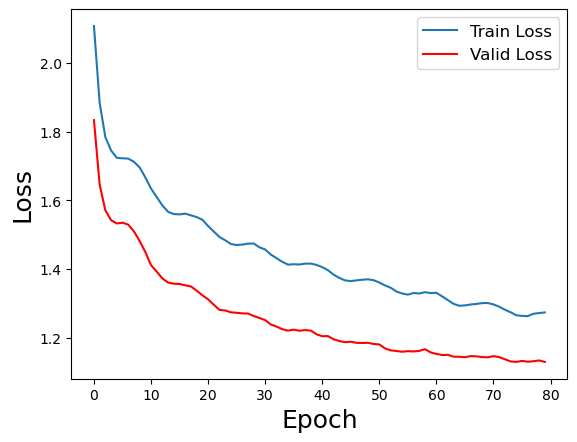

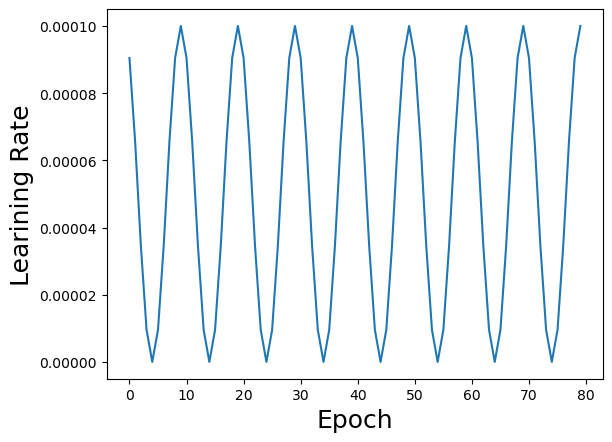

In [5]:
# Training
#store loss inf
loss={'train_loss':[],'valid_loss':[],'lr':[]}        

#early_stopping
patience=5
earlystop=0
best_loss=float('inf')
epochs = 100

for epoch in range(epochs):
    #model train
    model.train()
    tmp=[]
    with tqdm(trainLoader,leave=False) as tepoch:
        for inputs, target in tepoch:
            #set tqdm description
            tepoch.set_description(f'TrainEpoch{epoch+1:3d}')
            inputs, target=inputs.to(device), target.to(device)
            # Zero the parameter gradients
            optimizer.zero_grad()
            output = model(inputs)
            crit = criterion(output, target)

            tmp.append(crit.cpu().item())

            crit.backward()
            optimizer.step()
            tepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(tmp))})



    scheduler.step()
    loss['train_loss'].append(np.average(tmp))
    #model valid
    model.eval()
    tmp=[]
    with tqdm(validLoader,leave=False) as vepoch:
        for inputs, target in vepoch:
            vepoch.set_description(f'ValidEpoch{epoch+1:3d}')
            inputs,target=inputs.to(device), target.to(device)

            output=model(inputs)
            crit=criterion1(output,target)

            tmp.append(crit.cpu().item())
            vepoch.set_postfix({'loss':'{0:.3f}'.format(np.average(tmp))})

    loss['valid_loss'].append(np.average(tmp))
    loss['lr'].append(scheduler.get_last_lr())

    # earlystopping
    cur_loss=np.average(tmp)
    if cur_loss>best_loss:
        earlystop+=1
        if earlystop>= patience:
            print('Early stopping!')
            break
    else:
        earlystop=0
        best_loss=cur_loss

print('Finished Training')

#plot training loss and valid loss

plt.plot(loss['train_loss'])
plt.plot(loss['valid_loss'],color='r')
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Loss', fontsize=18)
plt.legend(["Train Loss", "Valid Loss"],fontsize=12)
plt.show()

#plot lr

plt.plot(loss['lr'])
plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Learining Rate', fontsize=18)
plt.show()

In [6]:
# export onnx model
dummy_input = torch.randn(1, 3, 32, 32).to(device)  
input_names = ["input"]
output_names = ["output"]
dynamic_axes = {"input": {0: "batch_size"}, "output": {0: "batch_size"}}
onnx_path = "model.onnx"
torch.onnx.export(model, dummy_input, onnx_path, input_names=input_names, output_names=output_names, dynamic_axes=dynamic_axes)

In [7]:
! pip install minio
from minio import Minio

#prepare config.pbtxt
content = """name: "cifar-10"
platform: "onnxruntime_onnx"
backend: "onnxruntime"
max_batch_size : 256
input [
  {
    name: "input"
    data_type: TYPE_FP32
    dims: [  3, 32, 32 ]

  }
]
output [
  {
    name: "output"
    data_type: TYPE_FP32
    dims: [ 10 ]
  }
]
"""

file_path = "config.pbtxt"
with open(file_path, "w") as file:
    file.write(content)

# minio info ()
minio_info = {'url': 'minio-api:9000',
              'accessKey': 'admin',
              'secretKey': 'admin123',
              'bucket': 'models', }


#model info
model_info = {'name': 'cifar-10',
              'version': '1', }
              
              

# minio config
clinet = Minio(
    minio_info['url'],
    access_key = minio_info['accessKey'],
    secret_key = minio_info['secretKey'],
    secure = False
)

#found = clinet.bucket_exists(bucket_name)
found = clinet.bucket_exists(minio_info['bucket'])
if not found:
    print(f"no {minio_info['bucket']} in {minio_info['url']}")

else:
    print(f"Bucket {minio_info['bucket']} is existed !")

    
    
    
    # store config.pbtxt
    store_path = f"{model_info['name']}/config.pbtxt"
    clinet.fput_object(
        minio_info['bucket'], store_path, 'config.pbtxt'
    )
    # store model.onnx
    store_path = f"{model_info['name']}/{model_info['version']}/model.onnx"
    clinet.fput_object(
        minio_info['bucket'], store_path, 'model.onnx'
    )

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 662.7 kB/s eta 0:00:00a 0:00:01
Bucket models is existed !


In [8]:
!pip install tritonclient
import tritonclient.grpc as grpcclient
from tritonclient.grpc import InferInput, InferRequestedOutput
triton_client = grpcclient.InferenceServerClient(url='triton-triton-inference-server:8001', verbose=0)


# Get model metadata
metadata = triton_client.get_model_metadata(model_name=model_info['name'], model_version=model_info['version'])
# Print the metadata
print("Model Metadata:")
print(metadata)
print('*'*50)
config = triton_client.get_model_config(model_name=model_info['name'], model_version=model_info['version'])
print("Model Config:")
print(config)

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.3/12.3 MB 10.4 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.1/20.1 MB 9.6 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 5.9 MB/s eta 0:00:0000:0100:01
Model Metadata:
name: "cifar-10"
versions: "1"
platform: "onnxruntime_onnx"
inputs {
  name: "input"
  datatype: "FP32"
  shape: -1
  shape: 3
  shape: 32
  shape: 32
}
outputs {
  name: "output"
  datatype: "FP32"
  shape: -1
  shape: 10
}

**************************************************
Model Config:
config {
  name: "cifar-10"
  platform: "onnxruntime_onnx"
  version_policy {
    latest {
      num_versions: 1
    }
  }
  max_batch_size: 256
  input {
    name: "input"
    data_type: TYPE_FP32
    dims: 3
    dims: 32
    dims: 32
  }
  output {
    name: "output"
    data_type: TYPE_FP32
    dims: 10
  }
  instance_group {
    name: "cifar-10"
    count: 1
    gpus: 0
    kind: KIND_GPU
  }
  default_model_filenam

In [9]:
test_acc={}
classes = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']
# Test
correct = 0
total = 0


triton_tgt=[]
with tqdm(testLoader, leave=True) as tepoch:
    for inputs, labels in tepoch:
       # Prepare inputs dictionary
        infer_inputs = [InferInput('input', inputs.shape, "FP32")]
        infer_inputs[0].set_data_from_numpy(inputs.numpy())

        # Perform inference using Triton client
        infer_outputs = [InferRequestedOutput('output')]  # Replace '34' with the appropriate output layer name
        response = triton_client.infer(model_name=model_info['name'], inputs=infer_inputs, model_version = model_info['version'], outputs=infer_outputs)

        pred = response.as_numpy('output')  
        correct += (np.argmax(pred,1) == labels.numpy()).sum().item()
        total+=labels.size(0)
        c=(np.argmax(pred,1) == labels.numpy()).squeeze()


        for i in range(labels.size(0)):
            label=labels[i].item()
            if label not in test_acc:
                test_acc[label]=[0,0]
            else:
                test_acc[label][0]+=c[i].item()
                test_acc[label][1]+=1

print('='*29) 
for i in range(len(classes)):
    print('Accuracy of %10s : %2d %%' % (classes[i], 100 * test_acc[i][0] / test_acc[i][1]))
print('='*29)        
print('Test Dataset : %d %%' % (100 * correct / total))   

100%|██████████| 157/157 [00:03<00:00, 43.97it/s] 

Accuracy of   Airplane : 66 %
Accuracy of Automobile : 75 %
Accuracy of       Bird : 42 %
Accuracy of        Cat : 44 %
Accuracy of       Deer : 52 %
Accuracy of        Dog : 48 %
Accuracy of       Frog : 71 %
Accuracy of      Horse : 69 %
Accuracy of       Ship : 76 %
Accuracy of      Truck : 64 %
Test Dataset : 61 %
